In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, accuracy_score, f1_score, roc_auc_score

Dataset Overview:

The dataset used for this project is the Loan Approval Classification Dataset, sourced from Kaggle. It contains  45,000 loan application records, with both numerical and categorical features related to the applicant’s demographics, financial status, and credit history.

The goal is to predict whether a loan application will be approved or rejected.

Modeling Approach

For this experiment, I used Logistic Regression as the type of model to perform binary classification. I scaled the numerical features using StandardScaler and encoded the categorical features appropriately.

The target variable for prediction is:
- loan_status → 1 (approved), 0 (rejected)


In [64]:
loan_data = pd.read_csv("../data/loan_data.csv")

In [65]:
education_map = {'High School': 0, 'Associate': 1, 'Bachelor':2, 'Master':3, 'Doctorate':4}

loan_data['person_education'] = loan_data['person_education'].map(education_map)


hot_enc_cols = ['person_gender', 'person_home_ownership','loan_intent', 'previous_loan_defaults_on_file']
loan_data = pd.get_dummies(loan_data, columns=hot_enc_cols,drop_first=True)


to_fix_col = loan_data.select_dtypes(include='bool').columns
loan_data[to_fix_col] = loan_data[to_fix_col].astype(int)


In [66]:
loan_data.head(5)
loan_data.describe()

,person_age,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender_male,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
count,45000.000000,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,1.383333,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222,0.552022,0.002600,0.065578,0.520956,0.203400,0.106289,0.189956,0.167822,0.173756,0.507956
std,6.045108,1.077741,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744,0.497292,0.050924,0.247545,0.499566,0.402532,0.308210,0.392270,0.373712,0.378903,0.499942
min,20.000000,0.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,1.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,30.000000,2.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,144.000000,4.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Overview of the MIA Pipeline

This notebook implements a modern membership inference attack (MIA) pipeline using:
- Shadow models (we will test on varying # of shadow models)
- Engineered features (confidence, entropy, loss, etc.)
- A single attack model

The goal is to compare attack performance before and after unlearning (retraining without the forget set) specific data.

Data Preparation and Forget Set Definition

Data Split:
- Split the loan dataset into 60% training and 40% test data
- Use stratified sampling to maintain class balance (loan approval rates)
- Set random seed for reproducibility

Forget Set Selection:
We define a forget set using a percentile threshold over 3 key features with significant weightage:
- High interest rate loans 
- High debt-to-income ratio loans 
- Large loan amounts 

This simulates a real-world scenario where a bank wants to unlearn risky loan patterns from their model due to regulatory changes or fairness concerns. So the forget set contains loan applications that meet at least one high-risk criterion.

In [67]:

#default
config = {'num_shadow_models': 10, 
          'random_seed': 42,
          'forget_percentile': .85}

In [68]:
scaler = StandardScaler()
train_data, test_data = train_test_split(
    loan_data, 
    test_size=0.4, 
    random_state=config['random_seed'], 
    stratify=loan_data['loan_status']
)

rate_threshold = train_data['loan_int_rate'].quantile(config['forget_percentile'])
percent_income_threshold = train_data['loan_percent_income'].quantile(config['forget_percentile'])
loan_amnt_threshold = train_data['loan_amnt'].quantile(config['forget_percentile'])

forget = train_data[
    (train_data['loan_int_rate'] >= rate_threshold) |
    (train_data['loan_percent_income'] >= percent_income_threshold) |
    (train_data['loan_amnt'] >= loan_amnt_threshold)
]

X_forget = forget.drop(columns=['loan_status'])
Y_forget = forget['loan_status']


Target Model Training (Original Model)

Model Configuration:
- Logistic Regression with high regularization (C=10000) to allow for overfitting
- High max_iter (10000) to ensure convergence

Training Process:
1. Use full training data (including forget set)
2. Split into train/test for model validation
3. Key strategy: Limit training to 900 samples to induce overfitting
4. Apply feature scaling using StandardScaler
5. Train on scaled features

Purpose: Small training size causes the model to memorize training examples, making membership inference attacks more effective. Without overfitting, member vs non-member patterns become indistinguishable.

Unlearned Model Training (After Forgetting)

Data Preparation:
- Remove forget set from training data (creating "keep" dataset)
- This simulates perfect unlearning - as if forget set never existed

Training Process:
1. Use identical model architecture and hyperparameters
2. Same 900-sample training size to maintain overfitting conditions
3. Use separate scaler (unlearn_scaler) to avoid data leakage
4. Train on reduced dataset that excludes forget set

Scaling Forget Set:
- Transform forget set using unlearn_scaler (not original scaler)
- This ensures forget set is processed as the unlearned model would see it

Purpose: Overfitted unlearned model will show clearly different confidence patterns on forget set, enabling strong membership inference attack evaluation.

In [69]:
target = LogisticRegression(C=10000, max_iter=10000)

X = train_data.drop('loan_status', axis=1)
Y = train_data['loan_status']

# Original training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=config['random_seed'])
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, train_size=900, random_state=config['random_seed'], stratify=Y_train
)

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

target.fit(X_train_scale, Y_train)

# Unlearned model
keep = train_data.drop(forget.index)
X_unlearn = keep.drop('loan_status', axis=1)
Y_unlearn = keep['loan_status']

X_train_unlearn, X_test_unlearn, Y_train_unlearn, Y_test_unlearn = train_test_split(
    X_unlearn, Y_unlearn, test_size=.2, random_state=config['random_seed']
)
X_train_unlearn, X_test_unlearn, Y_train_unlearn, Y_test_unlearn = train_test_split(
    X_train_unlearn, Y_train_unlearn, train_size=900, random_state=config['random_seed'], stratify=Y_train_unlearn
)

unlearn_scaler = StandardScaler()
X_train_unlearn_scale = unlearn_scaler.fit_transform(X_train_unlearn)
X_test_unlearn_scale = unlearn_scaler.transform(X_test_unlearn)

unlearn = LogisticRegression(C=10000, max_iter=10000)
unlearn.fit(X_train_unlearn_scale , Y_train_unlearn)
X_forget_scaled = unlearn_scaler.transform(X_forget)


Shadow Model Setup for Membership Inference Attack

Purpose: Create auxiliary models to generate labeled training data for our membership inference attack.

Data Partitioning Strategy:
1. Shuffle test dataset with fixed random seed for reproducibility
2. Split into equal chunks - one chunk per shadow model
3. Each chunk split 50/50 into shadow_train and shadow_test sets

Why This Design?
- Each shadow model gets completely disjoint training data
- We know exactly which samples each shadow model has "seen" (members) vs "not seen" (non-members)
- This creates the ground truth labels needed to train our attack model

Shadow Model Training

Training Process:
For each shadow model:
1. Separate scaler - prevents information leakage between shadow models
2. Identical architecture - same LogisticRegression(C=10000) as target models
3. Low regularization - allows overfitting to create detectable membership patterns
4. Feature scaling - standardize inputs for stable training

key Insight:
Each shadow model will overfit to its small training set, creating distinct confidence patterns for:
- Member data (data it was trained on) → High confidence
- Non-member data (held-out test data) → Lower confidence

Output:
- N trained shadow models with known member/non-member distinctions
- Scaled training data and scalers for consistent preprocessing
- Foundation for generating attack training data

In [70]:
num_shadow_models = config['num_shadow_models']
chunks = int(len(test_data) / num_shadow_models)
shuffled_df = test_data.sample(frac=1, random_state=config['random_seed']).reset_index(drop=True)
shadow_sets = []

for num in range(num_shadow_models):
    start_index = int(chunks * num)
    end_index = int(start_index + chunks)
    shadow_train, shadow_test = train_test_split(shuffled_df[start_index:end_index], test_size=.5, random_state=config['random_seed'])
    shadow_sets.append((shadow_train, shadow_test))

shadow_models = []
shadow_scaled_data = []
shadow_scalers = []

for num in range(num_shadow_models):
    shadow_scaler = StandardScaler()
    shadow_train = shadow_sets[num][0]
    X_shadow_train = shadow_train.drop('loan_status', axis=1)
    Y_shadow_train = shadow_train['loan_status']
    X_shadow_train_scaled = shadow_scaler.fit_transform(X_shadow_train)
    model = LogisticRegression(C=10000, max_iter=10000)
    model.fit(X_shadow_train_scaled, Y_shadow_train)

    shadow_models.append(model)
    shadow_scalers.append(shadow_scaler)
    shadow_scaled_data.append((X_shadow_train_scaled, Y_shadow_train))


Attack Feature Engineering

Purpose: Extract confidence-based features that reveal membership patterns from shadow models.

Feature Extraction Function:
- Input: Shadow models, their scalers, and datasets
- Output: Engineered features that capture membership signals

Engineered Features (4 per sample):
1. Max Confidence: Highest probability across all classes - measures model certainty
2. Entropy: Uncertainty measure - lower entropy indicates higher confidence
3. True Class Probability: Model's confidence in the correct label
4. Loss: Negative log-likelihood - higher loss indicates model struggled with prediction

Why These Features?
- Member data: Models are more confident → higher max_conf, lower entropy, higher true_class_proba, lower loss
- Non-member data: Models are less confident → lower max_conf, higher entropy, lower true_class_proba, higher loss

Generate Attack Training Dataset

Member Samples (Label = 1):
- Extract features from each shadow model's training data
- These are samples the shadow model has "seen" during training
- Expected pattern: High confidence, low entropy, low loss

Non-Member Samples (Label = 0):
- Extract features from each shadow model's held-out test data
- These are samples the shadow model has "never seen"
- Expected pattern: Lower confidence, higher entropy, higher loss

Result:
- Balanced dataset: Equal numbers of member (1) and non-member (0) samples
- Rich feature representation: 4 confidence-based features per sample
- Ground truth labels: We know exactly which samples are members vs non-members

This creates the supervised learning problem: "Given confidence features, predict if a sample was in the training set."

In [71]:
def extract_attack_features(models, scalers, datasets, member=True):
    features, labels = [], []
    label_value = 1 if member else 0

    for i in range(len(models)):
        model = models[i]
        scaler = scalers[i]
        if member:
            X_data_scaled, Y_data = datasets[i]
        else:
            test_df = shadow_sets[i][1]
            X_data = test_df.drop('loan_status', axis=1)
            Y_data = test_df['loan_status']
            X_data_scaled = scaler.transform(X_data)

        preds = model.predict(X_data_scaled)
        probs = model.predict_proba(X_data_scaled)
        max_conf = np.max(probs, axis=1)
        entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
        true_class_proba = probs[np.arange(len(Y_data)), Y_data]
        loss = -np.log(true_class_proba + 1e-8)

        attack_feat = np.column_stack([max_conf, entropy, true_class_proba, loss])
        features.append(attack_feat)
        labels.append(np.full(len(attack_feat), label_value))

    return np.vstack(features), np.hstack(labels)

member_feature, member_label = extract_attack_features(shadow_models, shadow_scalers, shadow_scaled_data, member=True)
non_member_feature, non_member_label = extract_attack_features(shadow_models, shadow_scalers, shadow_scaled_data, member=False)


Attack Model Training

Dataset Preparation:
- Combine member and non-member features into single training matrix
- Merge corresponding labels (1s for members, 0s for non-members)
- Result: Balanced binary classification dataset

Feature Standardization:
- Apply StandardScaler to attack features for stable training
- Ensures all engineered features (confidence, entropy, loss) are on similar scales
- Prevents any single feature from dominating the attack model

Attack Model Architecture:
- Logistic Regression - simple, interpretable binary classifier
- Purpose: Learn to distinguish member vs non-member confidence patterns
- Input: 4 standardized confidence features per sample
- Output: Probability that a sample was in the training set

What the Attack Model Learns:
The model discovers patterns like:
- "High confidence + low entropy + low loss → likely a member"
- "Low confidence + high entropy + high loss → likely a non-member"

Result: Trained attack model that can predict membership status given confidence features from any target model.

In [72]:
X_attack = np.vstack([member_feature, non_member_feature])
y_attack = np.hstack([member_label, non_member_label])
attack_scaler = StandardScaler()
X_attack_scale = attack_scaler.fit_transform(X_attack)

attack = LogisticRegression(max_iter=1000)
attack.fit(X_attack_scale, y_attack)


LogisticRegression(max_iter=1000)

Evaluation on Target Models

Feature Extraction for Evaluation:
- Extract the same 4 engineered features from both target and unlearned models
- Input: Forget set data (samples we want to test for membership)
- Output: Confidence features for attack model evaluation

Attack Evaluation Process:
1. Target Model: Extract features from model that saw the forget set during training
2. Unlearned Model: Extract features from model that never saw the forget set
3. Scale features using the same scaler fitted on attack training data
4. Apply attack model to predict membership for each sample

Expected Attack Behavior:
- Target Model Predictions: High attack accuracy (~80%+) 
 - Attack correctly identifies forget set as "members" (model has seen this data)
- Unlearned Model Predictions:** Lower attack accuracy (~50-60%)
 - Attack struggles to identify forget set as "members" (model never saw this data)

Privacy Gain Calculation

Evaluation Strategy:
- Ground Truth: All forget set samples are "members" (label = 1) for target model
- Attack Success: Measures how well attack model detects membership

Key Metrics:
- Target Accuracy: How often attack correctly identifies forget set as members in original model
- Unlearn Accuracy: How often attack identifies forget set as members in unlearned model  
- Privacy Gain: `target_accuracy - unlearn_accuracy`

Interpretation:
- High Privacy Gain (>20%): Unlearning successfully reduced membership leakage
- Low Privacy Gain (<5%): Unlearning was ineffective
- Negative Privacy Gain: Unlearning made things worse (shouldn't happen)

Expected Result: ~25% privacy gain, meaning unlearning reduced membership inference accuracy by 25 percentage points.

In [73]:
def get_attack_features(model, X_scaled, Y_true):
    probs = model.predict_proba(X_scaled)
    preds = model.predict(X_scaled)
    max_conf = np.max(probs, axis=1)
    entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
    true_class_proba = probs[np.arange(len(Y_true)), Y_true]
    loss = -np.log(true_class_proba + 1e-8)
    return np.column_stack([max_conf, entropy, true_class_proba, loss])

target_attack_features = get_attack_features(target, X_forget_scaled, Y_forget)
unlearn_attack_features = get_attack_features(unlearn, X_forget_scaled, Y_forget)

target_attack_scaled = attack_scaler.transform(target_attack_features)
unlearn_attack_scaled = attack_scaler.transform(unlearn_attack_features)

target_preds = attack.predict(target_attack_scaled)
unlearn_preds = attack.predict(unlearn_attack_scaled)

target_acc = accuracy_score(np.ones(len(target_preds)), target_preds)
unlearn_acc = accuracy_score(np.ones(len(unlearn_preds)), unlearn_preds)


In [74]:
attack_model = attack
attack_scaler= attack_scaler
target_model=target
unlearned_model = unlearn
target_attack_features_scaled=target_attack_scaled,
forget_set= forget
target_accuracy =target_acc
unlearn_accuracy=unlearn_acc

In [75]:
def calculate_model_metrics(model, X_scaled, y_true, model_name):
    
    predictions = model.predict(X_scaled)
    probabilities = model.predict_proba(X_scaled)[:, 1]  
    
    metrics = {
        f'{model_name}_accuracy': accuracy_score(y_true, predictions),
        f'{model_name}_f1': f1_score(y_true, predictions),
        f'{model_name}_auc': roc_auc_score(y_true, probabilities)
    }
    
    return metrics

In [76]:
#original standalone
def run_pipeline(config):
    scaler = StandardScaler()


    train_data, test_data = train_test_split(loan_data, test_size=0.4, random_state=config['random_seed'], stratify=loan_data['loan_status'])


    rate_threshold = train_data['loan_int_rate'].quantile(config['forget_percentile'])
    percent_income_threshold = train_data['loan_percent_income'].quantile(config['forget_percentile'])
    loan_amnt_threshold = train_data['loan_amnt'].quantile(config['forget_percentile'])


    forget = train_data[(train_data['loan_int_rate'] >= rate_threshold) |
                (train_data['loan_percent_income'] >= percent_income_threshold) |
                (train_data['loan_amnt'] >= loan_amnt_threshold)]


    X_forget = forget.drop(columns=['loan_status'])
    Y_forget = forget['loan_status']
    len(forget)


    target = LogisticRegression(C=10000, max_iter=10000)


    X = train_data.drop('loan_status', axis=1)
    Y =train_data['loan_status']


    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=config['random_seed'])


    #change
    # Find this line:
    X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train,
    train_size=900,  # CHANGE THIS TO 500
    random_state=config['random_seed'],
    stratify=Y_train
    )
    X_train_scale = scaler.fit_transform(X_train)
    X_test_scale = scaler.transform(X_test)


    target.fit(X_train_scale, Y_train)
    unlearn_scaler = StandardScaler()
    keep = train_data.drop(forget.index)




    unlearn = LogisticRegression(C=10000, max_iter=10000)


    X_unlearn = keep.drop('loan_status', axis=1)
    Y_unlearn =keep['loan_status']




    X_train_unlearn, X_test_unlearn, Y_train_unlearn, Y_test_unlearn = train_test_split(X_unlearn, Y_unlearn, test_size=.2, random_state=config['random_seed'])


    #change
    X_train_unlearn, X_test_unlearn, Y_train_unlearn, Y_test_unlearn = train_test_split(
    X_train_unlearn, Y_train_unlearn,
    train_size=900,
    random_state=config['random_seed'],
    stratify=Y_train_unlearn
    )


    X_train_unlearn_scale = unlearn_scaler.fit_transform(X_train_unlearn)
    X_test_unlearn_scale = unlearn_scaler.transform(X_test_unlearn)


    unlearn.fit(X_train_unlearn_scale , Y_train_unlearn)
    X_forget_scaled = unlearn_scaler.transform(X_forget)



    predictions = target.predict(X_forget_scaled)
    predictions_unlearn = unlearn.predict(X_forget_scaled)




    num_shadow_models = config['num_shadow_models']
    chunks = int(len(test_data)/num_shadow_models)
    shuffled_df = test_data.sample(frac=1, random_state=config['random_seed']).reset_index(drop=True)
    shadow_sets = []


    for num in range(num_shadow_models):
        start_index = int(chunks*num)
        end_index = int(start_index+chunks)


        shadow_train, shadow_test = train_test_split(shuffled_df[start_index:end_index], test_size=.5, random_state=config['random_seed'])
        shadow_sets.append((shadow_train, shadow_test))


    shadow_models = []
    shadow_scaled_data = []
    shadow_scalers =[]
    for num in range(num_shadow_models):
        shadow_scaler = StandardScaler()
        
        shadow_train = shadow_sets[num][0]
        X_shadow_train = shadow_train.drop('loan_status', axis=1)
        Y_shadow_train = shadow_train['loan_status']


        X_shadow_train_scaled = shadow_scaler.fit_transform(X_shadow_train)



        i = LogisticRegression(C=10000,max_iter=10000)
        i.fit(X_shadow_train_scaled, Y_shadow_train )


        shadow_scalers.append(shadow_scaler)
        shadow_scaled_data.append((X_shadow_train_scaled,Y_shadow_train))
        shadow_models.append((i))
    #test if #of shadow models changes
    member_feature= []
    member_label = []


    for num in range(num_shadow_models):


        model = shadow_models[num]
        scaled_data = shadow_scaled_data[num][0]
        Y_data = shadow_scaled_data[num][1]


        results = model.predict_proba(scaled_data)




        max_confidence = np.max(results, axis=1)
        entropy = -np.sum(results * np.log(results + 1e-8), axis=1)
        predictions = model.predict(scaled_data)
        true_class_proba = results[np.arange(len(Y_data)), Y_data]
        correctness = (predictions == Y_data).astype(int)
        loss = -np.log(true_class_proba + 1e-8)
        vectors = calculate_model_metrics(model, scaled_data, Y_data, num)
      


        attack_features = np.column_stack([
            max_confidence,
            entropy,
            true_class_proba,
            loss
        ])
        member_feature.append(attack_features)
        member_label.append(np.ones(len(attack_features)))


    non_member_feature= []
    non_member_label = []


    for num in range(num_shadow_models):


        model = shadow_models[num]
        test_set = shadow_sets[num][1]
        scaler = shadow_scalers[num]


        X_test = test_set.drop('loan_status', axis=1)
        Y_data_test = test_set['loan_status']
        X_test_scaled = scaler.transform(X_test)


        results = model.predict_proba(X_test_scaled)






        max_confidence = np.max(results, axis=1)
        entropy = -np.sum(results * np.log(results + 1e-8), axis=1)
        predictions = model.predict(X_test_scaled)
        true_class_proba = results[np.arange(len(Y_data_test)), Y_data_test]
        correctness = (predictions == Y_data_test).astype(int)
        loss = -np.log(true_class_proba + 1e-8)


        vectors = calculate_model_metrics(model, X_test_scaled, Y_data_test, num)
      


        attack_features = np.column_stack([
            max_confidence,
            entropy,
            true_class_proba,
            loss
        ])
        #print(attack_features)
        non_member_feature.append(attack_features)
        non_member_label.append(np.zeros(len(attack_features)))




    X_attack = np.vstack(member_feature + non_member_feature)
    y_attack = np.hstack(member_label + non_member_label)
    attack_scaler = StandardScaler()


    X_attack_scale = attack_scaler.fit_transform(X_attack)


    attack = LogisticRegression(max_iter=1000)
    attack.fit(X_attack_scale, y_attack)
    target_results = target.predict_proba(X_forget_scaled)

    max_confidence = np.max(target_results, axis=1)
    entropy = -np.sum(target_results * np.log(target_results + 1e-8), axis=1)
    target_predictions = target.predict(X_forget_scaled)
    true_class_proba = target_results[np.arange(len(Y_forget)), Y_forget]
    correctness = (target_predictions == Y_forget).astype(int)
    loss = -np.log(true_class_proba + 1e-8)


    target_attack_features = np.column_stack([
        max_confidence,
        entropy,
        true_class_proba,
        loss
    ])


    target_attack_features_scaled = attack_scaler.transform(target_attack_features)
    unlearn_results = unlearn.predict_proba(X_forget_scaled)


    max_confidence = np.max(unlearn_results, axis=1)
    entropy = -np.sum(unlearn_results * np.log(unlearn_results + 1e-8), axis=1)
    unlearn_predictions = unlearn.predict(X_forget_scaled)
    true_class_proba = unlearn_results[np.arange(len(Y_forget)), Y_forget]
    correctness = (unlearn_predictions == Y_forget).astype(int)
    loss = -np.log(true_class_proba + 1e-8)


    unlearn_attack_features = np.column_stack([
        max_confidence,
        entropy,
        true_class_proba,
        loss
    ])


    unlearn_attack_features_scaled = attack_scaler.transform(unlearn_attack_features)
    target_attack_predictions = attack.predict(target_attack_features_scaled)
    target_attack_accuracy = accuracy_score(np.ones(len(target_attack_predictions)), target_attack_predictions)
    unlearn_attack_predictions = attack.predict(unlearn_attack_features_scaled)
    unlearn_attack_accuracy = accuracy_score(np.ones(len(unlearn_attack_predictions)), unlearn_attack_predictions) 


    retain_metrics_original = calculate_model_metrics(target, scaler.transform(X_test_scale), Y_test, 'original_retain')
    retain_metrics_unlearned = calculate_model_metrics(unlearn, X_test_unlearn_scale, Y_test_unlearn, 'unlearned_retain')
    forget_metrics_original = calculate_model_metrics(target, scaler.transform(X_forget), Y_forget, 'original_forget')
    forget_metrics_unlearned = calculate_model_metrics(unlearn, X_forget_scaled, Y_forget, 'unlearned_forget')
    

    unlearn_attack_features_scaled = attack_scaler.transform(unlearn_attack_features)
    target_attack_predictions = attack.predict(target_attack_features_scaled)
    target_attack_accuracy = accuracy_score(np.ones(len(target_attack_predictions)), target_attack_predictions)
    unlearn_attack_predictions = attack.predict(unlearn_attack_features_scaled)
    unlearn_attack_accuracy = accuracy_score(np.ones(len(unlearn_attack_predictions)), unlearn_attack_predictions)
    
    
    return {
        'attack_model': attack,
        'attack_scaler': attack_scaler,
        'target_model': target,
        'unlearned_model': unlearn,
        'target_attack_features_scaled': target_attack_features_scaled,
        'forget_set': forget,
        'target_accuracy':target_attack_accuracy,
        'unlearn_accuracy':unlearn_attack_accuracy,
        'retain_metrics_original': retain_metrics_original,
        'retain_metrics_unlearned': retain_metrics_unlearned,
        'forget_metrics_original': forget_metrics_original,
        'forget_metrics_unlearned': forget_metrics_unlearned
    }

In [77]:
scenarios = [
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.85},
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.87},
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.89},
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.91},
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.93},
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.95},
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.97}
]

all_results = []

for scenario in scenarios:
    results = run_pipeline(scenario)
    all_results.append({
        'percentile': f"{scenario['forget_percentile']*100:.0f}th",
        'forget_size': len(results['forget_set']),
        'original_attack': f"{results['target_accuracy']*100:.1f}%",
        'unlearned_attack': f"{results['unlearn_accuracy']*100:.1f}%",
        'improvement': f"{(results['target_accuracy'] - results['unlearn_accuracy']) * 100:.1f}%"
    })

df = pd.DataFrame(all_results)
print(df)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have v

  percentile  forget_size original_attack unlearned_attack improvement
0       85th         9362           80.3%            55.3%       25.1%
1       87th         8368           81.2%            57.7%       23.5%
2       89th         7243           81.9%            66.8%       15.0%
3       91th         6244           82.3%            66.9%       15.3%
4       93th         5387           81.2%            76.7%        4.5%
5       95th         3635           80.2%            74.6%        5.6%
6       97th         2400           78.6%            77.0%        1.6%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [78]:
scenarios = [
    {'random_seed': 42, 'forget_percentile': 0.85, 'num_shadow_models': 10},
    { 'random_seed': 42,'forget_percentile': 0.90,'num_shadow_models': 10 },
    {'random_seed': 42,'forget_percentile': 0.95, 'num_shadow_models': 10}
]

all_results = []

for scenario in scenarios:
    results = run_pipeline(scenario)
    all_results.append({
    'percentile': f"{scenario['forget_percentile']*100:.0f}th",
    #'forget_size': len(results['forget_set']),
    'original_attack': f"{results['target_accuracy']*100:.1f}%",
    'unlearned_attack': f"{results['unlearn_accuracy']*100:.1f}%",
    'improvement': f"{(results['target_accuracy']-results['unlearn_accuracy'])*100:.1f}%",


   'retain_accuracy_original': f"{results['retain_metrics_original']['original_retain_accuracy']*100:.1f}%",
    'retain_f1_original': f"{results['retain_metrics_original']['original_retain_f1']*100:.1f}%",
    'retain_auc_original': f"{results['retain_metrics_original']['original_retain_auc']*100:.1f}%",


    'retain_accuracy_unlearned': f"{results['retain_metrics_unlearned']['unlearned_retain_accuracy']*100:.1f}%",
    'retain_f1_unlearned': f"{results['retain_metrics_unlearned']['unlearned_retain_f1']*100:.1f}%",
    'retain_auc_unlearned': f"{results['retain_metrics_unlearned']['unlearned_retain_auc']*100:.1f}%",
    

    'forget_accuracy_original': f"{results['forget_metrics_original']['original_forget_accuracy']*100:.1f}%",
    'forget_f1_original': f"{results['forget_metrics_original']['original_forget_f1']*100:.1f}%",
    'forget_auc_original': f"{results['forget_metrics_original']['original_forget_auc']*100:.1f}%",
    
    'forget_accuracy_unlearned': f"{results['forget_metrics_unlearned']['unlearned_forget_accuracy']*100:.1f}%",
    'forget_f1_unlearned': f"{results['forget_metrics_unlearned']['unlearned_forget_f1']*100:.1f}%",
    'forget_auc_unlearned': f"{results['forget_metrics_unlearned']['unlearned_forget_auc']*100:.1f}%",

})

df = pd.DataFrame(all_results)
print(df)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  percentile original_attack unlearned_attack improvement  \
0       85th           80.3%            55.3%       25.1%   
1       90th           82.3%            61.8%       20.5%   
2       95th           80.2%            74.6%        5.6%   

  retain_accuracy_original retain_f1_original retain_auc_original  \
0                    67.0%              55.2%               86.6%   
1                    67.0%              55.2%               86.6%   
2                    67.0%              55.2%               86.6%   

  retain_accuracy_unlearned retain_f1_unlearned retain_auc_unlearned  \
0                     91.1%               37.8%                91.2%   
1                     89.7%               47.7%                92.1%   
2                     89.0%               66.0%                93.9%   

  forget_accuracy_original forget_f1_original forget_auc_original  \
0                    83.9%              81.2%               94.0%   
1                    84.0%              84.0%      

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have v

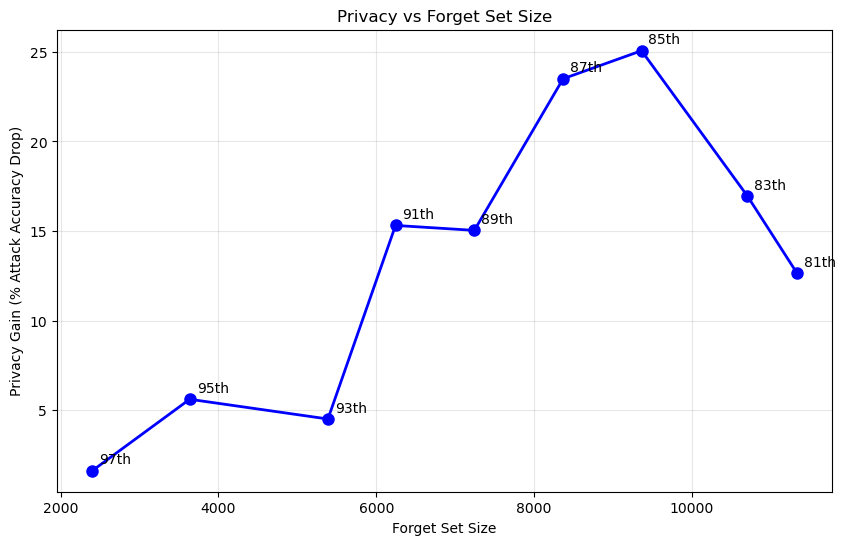

In [79]:
def analyze_forget_set_effects():
    percentiles = [ .81,.83,0.85, 0.87, 0.89, 0.91, 0.93, 0.95, 0.97]
    results = []
        
    for p in percentiles:
        config = {
                'forget_percentile': p,
                'random_seed': 42, 
                'num_shadow_models': 10,
                'training_size': 900
            }
            
        result = run_pipeline(config)
            
        results.append({
                'percentile': f"{p*100:.0f}th",
                'forget_size': len(result['forget_set']),
                'privacy_gain': (result['target_accuracy'] - result['unlearn_accuracy']) * 100,
                'target_acc': result['target_accuracy'] * 100,
                'unlearn_acc': result['unlearn_accuracy'] * 100
        })
        
    return results

results = analyze_forget_set_effects()

forget_sizes = [r['forget_size'] for r in results]
privacy_gains = [r['privacy_gain'] for r in results]
percentiles = [r['percentile'] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(forget_sizes, privacy_gains, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Forget Set Size')
plt.ylabel('Privacy Gain (% Attack Accuracy Drop)')
plt.title('Privacy vs Forget Set Size')
plt.grid(True, alpha=0.3)

for i, (x, y, label) in enumerate(zip(forget_sizes, privacy_gains, percentiles)):
    plt.annotate(label, (x, y), xytext=(5, 5), textcoords='offset points')

plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have v

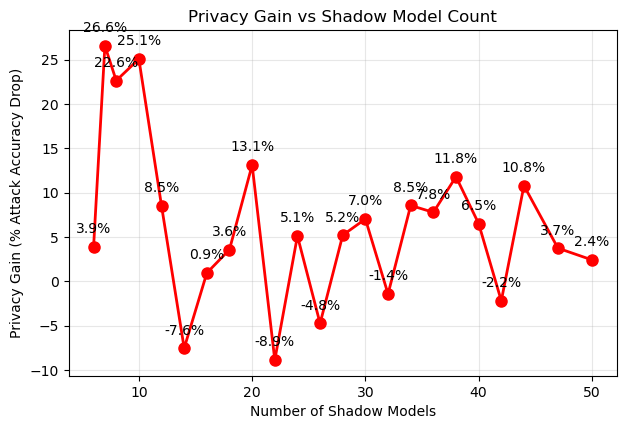


Shadow Model Count Analysis:
 6 models:   3.9% privacy gain, Target:  68.3%, Unlearn:  64.4%
 7 models:  26.6% privacy gain, Target:  64.6%, Unlearn:  38.1%
 8 models:  22.6% privacy gain, Target:  81.2%, Unlearn:  58.6%
10 models:  25.1% privacy gain, Target:  80.3%, Unlearn:  55.3%
12 models:   8.5% privacy gain, Target:  85.2%, Unlearn:  76.7%
14 models:  -7.6% privacy gain, Target:  33.3%, Unlearn:  40.8%
16 models:   0.9% privacy gain, Target:  35.9%, Unlearn:  34.9%
18 models:   3.6% privacy gain, Target:  86.4%, Unlearn:  82.8%
20 models:  13.1% privacy gain, Target:  84.1%, Unlearn:  71.0%
22 models:  -8.9% privacy gain, Target:  38.5%, Unlearn:  47.4%
24 models:   5.1% privacy gain, Target:  86.1%, Unlearn:  81.0%
26 models:  -4.8% privacy gain, Target:  41.8%, Unlearn:  46.6%
28 models:   5.2% privacy gain, Target:  86.1%, Unlearn:  80.9%
30 models:   7.0% privacy gain, Target:  85.7%, Unlearn:  78.7%
32 models:  -1.4% privacy gain, Target:  46.5%, Unlearn:  47.9%
34 models:

In [80]:
def analyze_shadow_model_effects():
    # Test different numbers of shadow models
    shadow_counts = [6, 7, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 47, 50]
    results = []
    
    for n_shadows in shadow_counts:
        config = {
            'forget_percentile': 0.85,  # Use optimal percentile from previous analysis
            'random_seed': 42,
            'num_shadow_models': n_shadows,
            'training_size': 900
        }
        
        result = run_pipeline(config)
      
        
        results.append({
            'n_shadow_models': n_shadows,
            'forget_size': len(result['forget_set']),
            'privacy_gain': (result['target_accuracy'] - result['unlearn_accuracy']) * 100,
            'target_acc': result['target_accuracy'] * 100,
            'unlearn_acc': result['unlearn_accuracy'] * 100,
            'non_member_detection': (1 - result['unlearn_accuracy']) * 100,
         
        })
    
    return results

# Run the analysis
shadow_results = analyze_shadow_model_effects()

# Extract data for plotting
shadow_counts = [r['n_shadow_models'] for r in shadow_results]
privacy_gains = [r['privacy_gain'] for r in shadow_results]
target_accs = [r['target_acc'] for r in shadow_results]
unlearn_accs = [r['unlearn_acc'] for r in shadow_results]

# Create the plot
plt.figure(figsize=(12, 8))

# Main plot: Privacy Gain vs Shadow Model Count
plt.subplot(2, 2, 1)
plt.plot(shadow_counts, privacy_gains, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Shadow Models')
plt.ylabel('Privacy Gain (% Attack Accuracy Drop)')
plt.title('Privacy Gain vs Shadow Model Count')
plt.grid(True, alpha=0.3)

# Annotate points
for x, y in zip(shadow_counts, privacy_gains):
    plt.annotate(f'{y:.1f}%', (x, y), xytext=(0, 10), textcoords='offset points', ha='center')


plt.tight_layout()
plt.show()

# Print summary
print("\nShadow Model Count Analysis:")
print("=" * 50)
for r in shadow_results:
    print(f"{r['n_shadow_models']:2d} models: {r['privacy_gain']:5.1f}% privacy gain, "
          f"Target: {r['target_acc']:5.1f}%, Unlearn: {r['unlearn_acc']:5.1f}%")

# Find optimal number
best_idx = max(range(len(shadow_results)), key=lambda i: shadow_results[i]['privacy_gain'])
optimal = shadow_results[best_idx]
print(f"\nOptimal: {optimal['n_shadow_models']} shadow models with {optimal['privacy_gain']:.1f}% privacy gain")
# Check shadow model chunk sizes and performance

Limited evaluation on different data types/models
No standardized benchmarks for "how unlearned is unlearned enough?"
What's the privacy-utility tradeoff curve?